In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Using TensorFlow backend.


In [27]:
def encode_words(model_name_or_path, sentences):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in indexed_tokens]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(indexed_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, sum the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, sentences, words_of_interest, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    embeddings = []
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if words_of_interest[i] in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            word_embedding = df.loc[(df['Sentence']==sent) & (df['Token']==words_of_interest[i]), ~df.columns.isin(['Token','Sentence'])].values[0]
            embeddings.append(word_embedding)

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(words_of_interest[i])
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
    
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(len(embeddings[0]))]
    df = pd.DataFrame(data=np.array(embeddings), columns=cols)
    df['Word'] = words_of_interest
    return df


def perform_tsne(df_embeddings):
    """
    """
    df = df_embeddings.copy(deep=True)
    
    ## Use PCA to reduce dimensions to a number that's manageable for t-SNE
    data = df.loc[:, df.columns != 'Word'].values
    pca_result_50 = data
    #pca_50 = PCA(n_components=50, random_state=42)
    #pca_result_50 = pca_50.fit_transform(data)
    #print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

    # Reduce dimensionality to 3 with t-SNE.
    tsne = TSNE(n_components=3, 
                perplexity=10, # usually in the range [5, 50] -> perplexity is related to the number of nearest neighbors (larger datasets usually require a larger perplexity).
                n_iter=2000, 
                learning_rate = 200, # usually in the range [10, 1000] -> If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours.
                random_state = 42, 
                verbose=0)
    tsne_pca_results = tsne.fit_transform(pca_result_50)

    # Add results to dataframe
    df['tsne-1'] = tsne_pca_results[:,0]
    df['tsne-2'] = tsne_pca_results[:,1]
    df['tsne-3'] = tsne_pca_results[:,2]
    
    return df


def plot_embeddings(tsne_df):
    """
    """
    fig = plt.figure(figsize=(22,7))

    # 2D
    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(x = tsne_df['tsne-1'], y = tsne_df['tsne-2'])

    # 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(xs=tsne_df["tsne-1"], ys=tsne_df["tsne-2"], zs=tsne_df["tsne-3"], cmap='tab10')
    ax2.set_xlabel('tsne-1', labelpad=10, fontsize=18)
    ax2.set_ylabel('tsne-2', labelpad=10, fontsize=18)
    ax2.set_zlabel('tsne-3', labelpad=10, fontsize=18)

    # Annotate points with labels.
    for line in tsne_df.index:
        ax1.text(tsne_df.loc[line,"tsne-1"]+0.07, 
                 tsne_df.loc[line,"tsne-2"], 
                 tsne_df.loc[line,"Word"], 
                 horizontalalignment='left', 
                 size=14, 
                 color='gray', 
                 weight='semibold')
        ax2.text(tsne_df.loc[line,"tsne-1"]+0.07, 
                 tsne_df.loc[line,"tsne-2"], 
                 tsne_df.loc[line,"tsne-3"], 
                 tsne_df.loc[line,"Word"], 
                 horizontalalignment='left', 
                 size=14, 
                 color='gray', 
                 weight='semibold')
    fig.show()
    return


def run_all(tuples):
    """
    """
    sentences = [x[0] for x in tuples]
    words_of_interest = [x[1] for x in tuples]
    classes = [x[2] for x in tuples]
    
    #--------------
    # Encode words
    #--------------
    print("BERT-base")
    bert_df = encode_words('bert-base-cased', sentences)
    bert_embeddings = get_embeddings(bert_df, sentences, words_of_interest, 'bert-base-cased')
    
    print("NetBERT")
    netbert_df = encode_words('../_models/netbert-final/', sentences)
    netbert_embeddings = get_embeddings(netbert_df, sentences, words_of_interest, '../_models/netbert-final/')
    
    
    #-----------------------
    # Perform tsne reduction
    #-----------------------
    bert_tsne = perform_tsne(bert_embeddings)
    netbert_tsne = perform_tsne(netbert_embeddings)
    
    #-----------------------
    # Plot reduced embeddings
    #-----------------------
    plot_embeddings(bert_tsne)
    plot_embeddings(netbert_tsne)
    
    return 

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 11 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 11 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


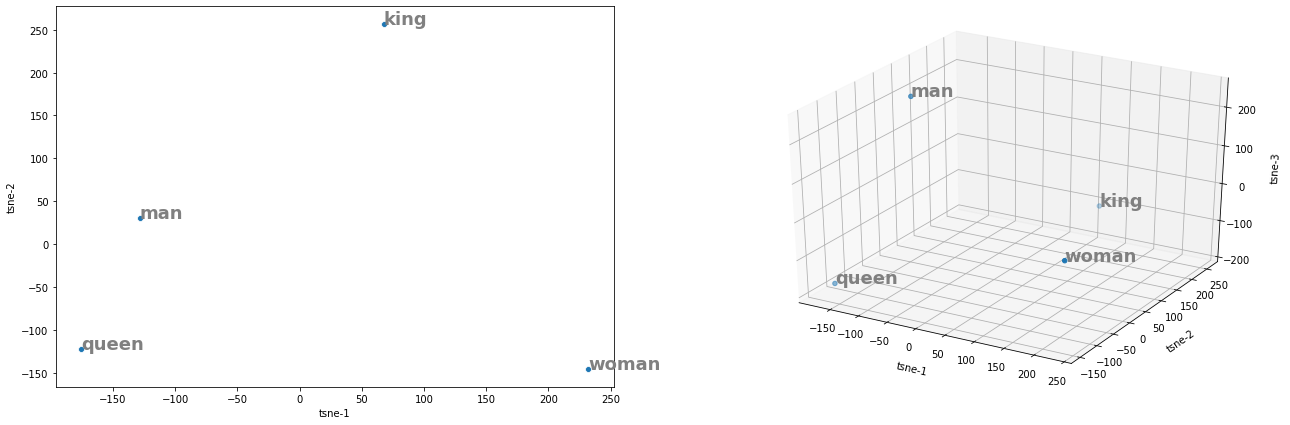

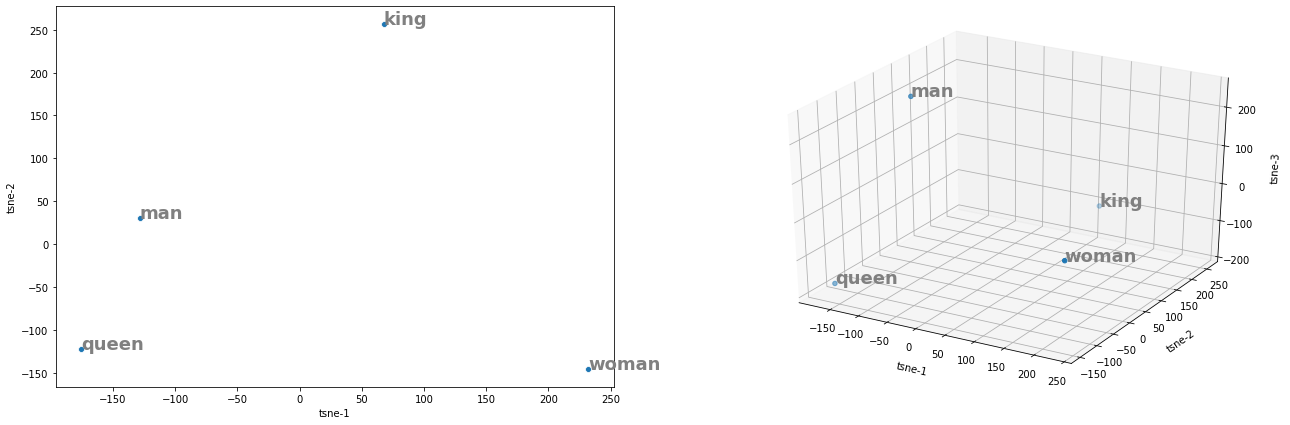

In [28]:
tuples = [("A man is an adult male person.", 'man', 'id1'),
             ("A woman is an adult female person.", 'woman', 'id1'),
             ("A king is a male sovereign or monarch.", 'king', 'id2'),
             ("A queen is a female sovereign or monarch.", 'queen', 'id2')]
res = run_all(tuples)